# AACR slides: Violin plot for the CTC cohort

### Mount data directory

In [1]:
!gcsfuse --implicit-dirs scrnaseq_benchmarking ~/data/

2022/03/16 22:49:29.589505 Start gcsfuse/0.40.0 (Go version go1.17.6) for app "" using mount point: /home/jtsuji/data
2022/03/16 22:49:29.640150 Opening GCS connection...
2022/03/16 22:49:29.806460 Mounting file system "scrnaseq_benchmarking"...
2022/03/16 22:49:29.810747 File system has been successfully mounted.


### Load libraries

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

### Load AnnData

In [3]:
# (69.12 GiB) gs://scrnaseq_benchmarking/aacr/mal_cells_for_junko_adata.h5ad
adata = sc.read_h5ad("/home/jtsuji/data/aacr/mal_cells_for_junko_adata.h5ad")

adata.obs

,latent_RT_efficiency,latent_cell_probability,latent_scale,cell_type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,scrublet_score,doublet,sample_id,bcr_raw_clonotype_id,bcr_clono_co,batch,plas_call
barcode,,,,,,,,,,,,,,,,
GACAGAGAGTGACTCT-1-0-0,2.680493,0.999986,6747.285156,TPC,3443,32340.0,214.0,0.661719,3443,0.058954,False,pM10109_1_BM_CD138pos_GEX_5,clonotype1,c1,0,tum
CATCGAATCATTGCGA-1-0-0,2.592071,0.999983,6423.836426,TPC,3061,31452.0,162.0,0.515071,3061,0.040225,False,pM10109_1_BM_CD138pos_GEX_5,clonotype1,c1,0,tum
AGCAGCCAGGACAGAA-1-0-0,2.554361,0.999979,6736.926758,TPC,3295,29711.0,223.0,0.750564,3295,0.130590,False,pM10109_1_BM_CD138pos_GEX_5,clonotype1,c1,0,tum
GCGACCATCCGAAGAG-1-0-0,2.505002,0.999977,7024.260742,TPC,3232,29400.0,267.0,0.908163,3232,0.117207,False,pM10109_1_BM_CD138pos_GEX_5,clonotype1,c1,0,tum
TTCTCAATCTAGCACA-1-0-0,2.694450,0.999979,7314.036133,TPC,3737,29220.0,355.0,1.214921,3737,0.219448,True,pM10109_1_BM_CD138pos_GEX_5,clonotype1,c1,0,tum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTATTCTCAAGCCTA-1-8-10,0.559692,0.999015,7608.150879,LQTPC,569,827.0,58.0,7.013301,569,0.051087,True,pM1831_2_PB_CD138pos_GEX_5,NaN,NA,10,tum
AGATTGCGTAAGTAGT-1-8-10,0.653077,0.999217,7586.197754,LQTPC,452,736.0,135.0,18.342390,452,0.007548,False,pM1831_2_PB_CD138pos_GEX_5,NaN,NA,10,tum
GACTAACCACGCTTTC-1-8-10,0.757090,0.998454,7705.398926,LQTPC,566,770.0,45.0,5.844156,566,0.145455,True,pM1831_2_PB_CD138pos_GEX_5,NaN,NA,10,tum


### Combine metadata with AnnData

In [4]:
import copy

# load metadata
meta = pd.read_csv("/home/jtsuji/mm-single-cell-analysis-2022/notebooks/violin_metadata.csv", dtype=str)
meta['patient_id'] = meta["PAIR_NUMBER"]+"_"+meta["DISEASE_STAGE"]

# define new column names to link with AnnData ('patient_id' is new)
#          old column               new column
cols  = { "patient_id"           : "patient_id",
          "REDCAP_ID"            : "redcap_id",
          "tissue_type"          : "tissue_type",
          "IMMUNOFIX_LIGHT_CHAIN": "ifx",
          "DISEASE_STAGE"        : "disease",
          "20_2_20_RISK_STATUS"  : "risk",
          "CG"                   : "group" }

# create sample ID based dictionary from metadata
meta_dict = dict()
for i, row in meta.iterrows():
    row_i = dict(row[[c for c in cols.keys() if c != "tissue_type"]])
    for bm_id in row["BM_CATISSUE_SAMPLE_ID"].split("/"):
        meta_dict.setdefault(bm_id, copy.deepcopy(row_i))
        meta_dict[bm_id]["tissue_type"] = "BM"
    for ctc_id in row["CTC_CATISSUE_SAMPLE_ID"].split("/"):
        meta_dict.setdefault(ctc_id, copy.deepcopy(row_i))
        meta_dict[ctc_id]["tissue_type"] = "CTC"
for meta_col, new_col in cols.items():
    adata.obs[new_col] = pd.Series(np.full(adata.n_obs, np.nan), dtype=str)

# iterate and insert data
# this adata object is index by cell barcode (e.g. 'GACAGAGAGTGACTCT-1-0-0')
for cb, row in adata.obs.iterrows():
    sid = adata.obs.loc[cb, "sample_id"].split("_")[0]
    for meta_col in map(str, meta_dict[sid].keys()):
        adata.obs.at[cb, cols[meta_col]] = meta_dict[sid][meta_col]
 
adata.obs

,latent_RT_efficiency,latent_cell_probability,latent_scale,cell_type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,scrublet_score,...,bcr_clono_co,batch,plas_call,patient_id,redcap_id,tissue_type,ifx,disease,risk,group
barcode,,,,,,,,,,,,,,,,,,,,,
GACAGAGAGTGACTCT-1-0-0,2.680493,0.999986,6747.285156,TPC,3443,32340.0,214.0,0.661719,3443,0.058954,...,c1,0,tum,3_SMM,PANGEA_3522,BM,IgG_Kappa,SMM,HRSMM,HRD
CATCGAATCATTGCGA-1-0-0,2.592071,0.999983,6423.836426,TPC,3061,31452.0,162.0,0.515071,3061,0.040225,...,c1,0,tum,3_SMM,PANGEA_3522,BM,IgG_Kappa,SMM,HRSMM,HRD
AGCAGCCAGGACAGAA-1-0-0,2.554361,0.999979,6736.926758,TPC,3295,29711.0,223.0,0.750564,3295,0.130590,...,c1,0,tum,3_SMM,PANGEA_3522,BM,IgG_Kappa,SMM,HRSMM,HRD
GCGACCATCCGAAGAG-1-0-0,2.505002,0.999977,7024.260742,TPC,3232,29400.0,267.0,0.908163,3232,0.117207,...,c1,0,tum,3_SMM,PANGEA_3522,BM,IgG_Kappa,SMM,HRSMM,HRD
TTCTCAATCTAGCACA-1-0-0,2.694450,0.999979,7314.036133,TPC,3737,29220.0,355.0,1.214921,3737,0.219448,...,c1,0,tum,3_SMM,PANGEA_3522,BM,IgG_Kappa,SMM,HRSMM,HRD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTATTCTCAAGCCTA-1-8-10,0.559692,0.999015,7608.150879,LQTPC,569,827.0,58.0,7.013301,569,0.051087,...,NA,10,tum,44_NDMM,PANGEA_4610,CTC,IgA_Lambda.Light_Chain_Only_Lambda,NDMM,NA_NDMM,t(14;16)
AGATTGCGTAAGTAGT-1-8-10,0.653077,0.999217,7586.197754,LQTPC,452,736.0,135.0,18.342390,452,0.007548,...,NA,10,tum,44_NDMM,PANGEA_4610,CTC,IgA_Lambda.Light_Chain_Only_Lambda,NDMM,NA_NDMM,t(14;16)
GACTAACCACGCTTTC-1-8-10,0.757090,0.998454,7705.398926,LQTPC,566,770.0,45.0,5.844156,566,0.145455,...,NA,10,tum,44_NDMM,PANGEA_4610,CTC,IgA_Lambda.Light_Chain_Only_Lambda,NDMM,NA_NDMM,t(14;16)


### Violin plot

In [33]:
import matplotlib.pylab as plt
import seaborn as sns

plt.rcParams["pdf.fonttype"] = 42
sns.set_style("white")
    
def stacked_split_violin(df, genes, x="patient_id", hue="tissue_type", order=None, linewidth=0.08):
    fig, axes = plt.subplots(nrows=len(genes),
                             ncols=1,
                             figsize=(14, len(genes)),
                             sharex=True,
                             gridspec_kw=dict(hspace=0))
    for i,g in enumerate(genes):
        ax = sns.violinplot(data=df,
                            x=x,
                            y=g,
                            hue=hue,
                            inner=None,
                            linewidth=linewidth,
                            split=True,
                            order=order,
                            ax=axes[i])
        ax.set_ylabel(g, rotation=0, ha="right")
        ax.set_yticklabels([])
        # legend setting
        if i == 0:
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        else:
            ax.legend([], [], frameon=False)
        if i == len(genes)-1 and order != None:
            ax.set_xticklabels(order, rotation=90)

Normal
['8_SMM', '9_SMM', '11_SMM', '12_SMM', '14_SMM', '15_SMM', '21_MGUS', '27_SMM', '33_SMM', '34_SMM', '38_SMM', '39_SMM']
t(4;14)
['2_SMM', '5_SMM', '23_SMM']
t(11;14)
['10_SMM', '16_SMM', '24_NDMM', '29_NDMM', '30_SMM', '32_MGUS', '36_NDMM', '41_SMM']
t(14;16)
['6_SMM', '17_SMM', '44_NDMM']
t(x;14)
['4_SMM', '25_SMM', '42_MGUS']
Del14q
['19_SMM', '22_SMM']
HRD_Del14q
['7_SMM', '20.1_SMM', '20.2_SMM']
HRD_t(11;14)
['31_SMM']
HRD
['3_SMM', '13_SMM', '28_SMM', '40_SMM']
Fail
['1_SMM', '18_SMM', '26_SMM', '35_MGUS', '37_MGUS', '43_MGUS']


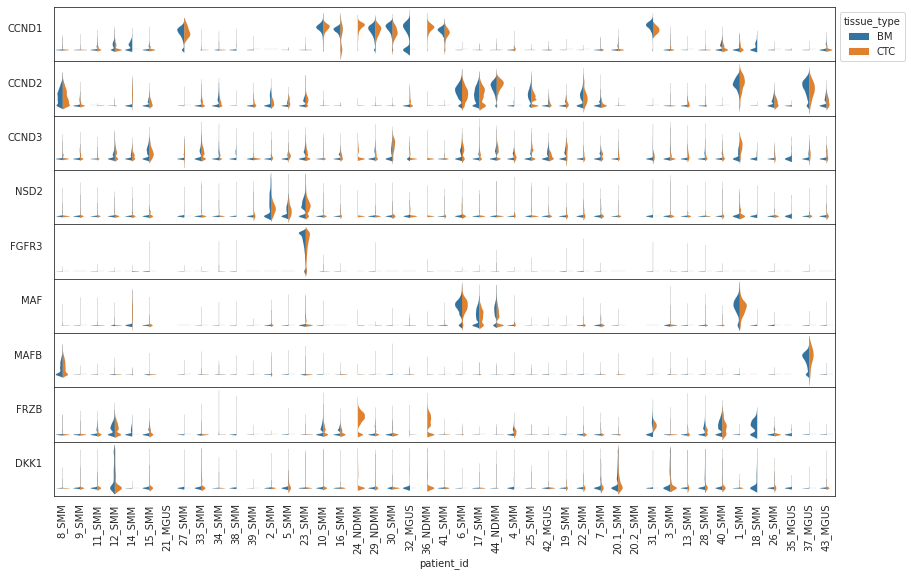

In [39]:
# get grouped patient_id by the clinical groups
group_order = ["Normal", "t(4;14)", "t(11;14)", "t(14;16)", "t(x;14)",
               "Del14q", "HRD_Del14q", "HRD_t(11;14)", "HRD", "Fail"]

# get ordered samples with the clinical grouping
sample_order = []
for g in group_order:
    s = list(meta[meta["CG"] == g]["patient_id"])
    sample_order.extend(s)
    print(g)
    print(s)
    
# plot figure 1B
df = sc.get.obs_df(adata, ["patient_id", "tissue_type"]+marker_genes).reset_index()
marker_genes = ["CCND1", "CCND2", "CCND3", "NSD2", "FGFR3", "MAF", "MAFB", "FRZB", "DKK1"]
stacked_split_violin(df, marker_genes,
                     x="patient_id", hue="tissue_type",
                     order=sample_order, linewidth=0.08)
plt.savefig("/home/jtsuji/mm-single-cell-analysis-2022/figures/ctc_paper/fig1b.pdf")

In [36]:
adata.obs.columns

Index(['latent_RT_efficiency', 'latent_cell_probability', 'latent_scale',
       'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'n_genes', 'scrublet_score', 'doublet', 'sample_id',
       'bcr_raw_clonotype_id', 'bcr_clono_co', 'batch', 'plas_call',
       'patient_id', 'redcap_id', 'tissue_type', 'ifx', 'disease', 'risk',
       'group'],
      dtype='object')